In [1]:
# Cell 1 — install deps
!pip -q install -U qdrant-client sentence-transformers
!pip -q install -U transformers accelerate pynvml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.2/377.2 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 54.1 MB/s eta 0:00:00


In [1]:
# Cell 2 — load Colab Secrets, validate, create client (no secret printing)

import os
from google.colab import userdata
from qdrant_client import QdrantClient

def get_secret(name: str) -> str:
    val = userdata.get(name)
    if val is None or str(val).strip() == "":
        raise ValueError(
            f"Missing secret: {name}. Add it in Colab Secrets as '{name}'."
        )
    return str(val).strip()

QDRANT_URL = get_secret("QDRANT_URL")
QDRANT_API_KEY = get_secret("QDRANT_API_KEY")
QDRANT_COLLECTION = get_secret("QDRANT_COLLECTION")

# Optional: set env vars (safe; we won't print them)
os.environ["QDRANT_URL"] = QDRANT_URL
os.environ["QDRANT_API_KEY"] = QDRANT_API_KEY
os.environ["QDRANT_COLLECTION"] = QDRANT_COLLECTION

# Use os.getenv (per requirement)
url = os.getenv("QDRANT_URL")
api_key = os.getenv("QDRANT_API_KEY")
collection = os.getenv("QDRANT_COLLECTION")

if not url or not api_key or not collection:
    raise ValueError(
        "Secrets were not loaded into environment variables correctly. "
        "Ensure QDRANT_URL, QDRANT_API_KEY, QDRANT_COLLECTION exist in Colab Secrets."
    )

client = QdrantClient(url=url, api_key=api_key)


In [2]:
# Cell 3  — sanity checks + retrieval using query_points (new qdrant-client API)

import os
from sentence_transformers import SentenceTransformer

collection = os.getenv("QDRANT_COLLECTION")
url = os.getenv("QDRANT_URL")

print(f"Qdrant URL (non-sensitive): {url}")
print(f"Collection: {collection}")

# 1) Collection info
info = client.get_collection(collection_name=collection)
vec_cfg = getattr(info.config.params, "vectors", None)

vec_summary = None
if vec_cfg is not None:
    try:
        # single-vector config
        vec_summary = {"size": vec_cfg.size, "distance": str(vec_cfg.distance)}
    except Exception:
        # named vectors config
        try:
            vec_summary = {k: {"size": v.size, "distance": str(v.distance)} for k, v in vec_cfg.items()}
        except Exception:
            vec_summary = "unavailable"

print("Collection config vectors:", vec_summary)

# 2) Count points
cnt = client.count(collection_name=collection, exact=True).count
print(f"Point count (exact): {cnt}")

if cnt == 0:
    print("Collection is empty. Ingest documents first, then re-run this sanity check.")
else:
    # 3) Retrieval test
    model_name = "sentence-transformers/all-MiniLM-L6-v2"
    embedder = SentenceTransformer(model_name)

    query = "What is TTFT?"
    qvec = embedder.encode(query, normalize_embeddings=True).tolist()  # dim=384

    # New API: query_points
    resp = client.query_points(
        collection_name=collection,
        query=qvec,
        limit=3,
        with_payload=True,
        with_vectors=False,
    )

    # resp can be either a list (older style) or an object with .points (newer style)
    hits = resp.points if hasattr(resp, "points") else resp

    print(f"Top-{len(hits)} hits for query: {query!r}")
    for i, h in enumerate(hits, 1):
        payload = getattr(h, "payload", None) or {}
        score = getattr(h, "score", None)

        doc_id = payload.get("doc_id") or payload.get("document_id") or payload.get("source") or "N/A"
        chunk_id = payload.get("chunk_id") or payload.get("chunk") or payload.get("id") or "N/A"
        text = payload.get("text") or payload.get("content") or payload.get("chunk_text") or ""
        text_preview = (text[:200] + ("…" if len(text) > 200 else "")) if isinstance(text, str) else ""

        if score is None:
            # Some client versions use 'score' always; keeping fallback just in case
            score = float("nan")

        print(f"{i}. score={score:.4f} | doc_id={doc_id} | chunk_id={chunk_id}")
        print(f"   text: {text_preview if text_preview else '(no text payload field found)'}")


/usr/local/lib/python3.12/dist-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Qdrant URL (non-sensitive): https://b2076804-ac4a-4684-ace3-7403e1f0ed4f.us-west-1-0.aws.cloud.qdrant.io:6333
Collection: gpu_llm_docs
Collection config vectors: {'size': 384, 'distance': 'Cosine'}
Point count (exact): 36


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Top-3 hits for query: 'What is TTFT?'
1. score=0.5067 | doc_id=ttft_definition | chunk_id=1
   text: takes longer, early feedback improves UX. Lower TTFT results in: - Faster perceived response - Higher user satisfaction - More interactive system feel --- ## Factors Affecting TTFT - Prompt length - M…
2. score=0.4208 | doc_id=ttft_definition | chunk_id=N/A
   text: # Time To First Token (TTFT) in Large Language Model Serving ## Introduction Time To First Token (TTFT) is a key metric in LLM serving systems. It measures the time between submitting a request and re…
3. score=0.3897 | doc_id=ttft_definition | chunk_id=2
   text: graph interpretation - Fusing kernels - Optimizing memory access --- ## Routing Implications Routing systems may: - Prefer optimized backend for short prompts to reduce TTFT - Use fallback for memory-…


## Baseline Implementation

In [4]:
# Fix cell — pin compatible versions (then RESTART runtime)
!pip -q uninstall -y transformers accelerate
!pip -q install "transformers==4.45.2" "accelerate==0.34.2"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.4/566.4 kB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 100.6 MB/s eta 0:00:00


In [3]:
# Cell A — Phase 1: retrieval (defines retrieve)

import os
from typing import List, Dict, Tuple

from sentence_transformers import SentenceTransformer

COLLECTION = os.getenv("QDRANT_COLLECTION") or "docs"

EMBED_MODEL = "sentence-transformers/all-MiniLM-L6-v2"
embedder = SentenceTransformer(EMBED_MODEL)

def retrieve(question: str, top_k: int = 4) -> Tuple[str, List[Dict]]:
    if not question or not question.strip():
        raise ValueError("Question is empty.")

    qvec = embedder.encode(question, normalize_embeddings=True).tolist()

    resp = client.query_points(
        collection_name=COLLECTION,
        query=qvec,
        limit=top_k,
        with_payload=True,
        with_vectors=False,
    )
    points = resp.points if hasattr(resp, "points") else resp

    hits: List[Dict] = []
    texts: List[str] = []

    for p in points:
        payload = getattr(p, "payload", None) or {}
        text = payload.get("text") or payload.get("content") or payload.get("chunk_text") or ""

        hits.append({
            "score": float(getattr(p, "score", 0.0)),
            "doc_id": payload.get("doc_id") or payload.get("document_id") or payload.get("source") or "N/A",
            "chunk_id": payload.get("chunk_id") or payload.get("chunk") or "N/A",
            "source": payload.get("source") or "N/A",
            "text": text,
        })

        if isinstance(text, str) and text.strip():
            texts.append(text.strip())

    context = "\n\n---\n\n".join(texts)
    return context, hits

# quick sanity check
ctx, hs = retrieve("What is TTFT?", top_k=4)
print("retrieve() OK | hits:", len(hs), "| context chars:", len(ctx))

retrieve() OK | hits: 4 | context chars: 2500


In [4]:
# Cell 2 — Phase 2: baseline HF inference on

import time
import threading
import torch

from transformers import AutoTokenizer, AutoModelForCausalLM, TextIteratorStreamer

# Pick a public, small baseline that downloads reliably without HF token
# You can swap later to a stronger model once everything works.
BASELINE_MODEL = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

tokenizer = AutoTokenizer.from_pretrained(BASELINE_MODEL, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(
    BASELINE_MODEL,
    torch_dtype=torch.float16,
    device_map="auto",
)
model.eval()

SYSTEM_INSTRUCTION = "Answer using only the provided context. If the answer is not in the context, say: 'I don't know based on the provided context.'"

def build_rag_prompt(context: str, question: str) -> str:
    # Simple, consistent prompt. (Chat template varies by model; this works generally.)
    return (
        f"System:\n{SYSTEM_INSTRUCTION}\n\n"
        f"Context:\n{context}\n\n"
        f"Question:\n{question}\n\n"
        f"Answer:"
    )

@torch.inference_mode()
def generate_baseline_with_metrics(question: str, top_k: int = 4, max_new_tokens: int = 200):
    context, hits = retrieve(question, top_k=top_k)

    if not context.strip():
        print("No context retrieved (empty text payloads). Check ingestion payload fields.")
        return None

    prompt = build_rag_prompt(context, question)

    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"].to(model.device)
    attn_mask = inputs.get("attention_mask", None)
    if attn_mask is not None:
        attn_mask = attn_mask.to(model.device)

    input_len = int(input_ids.shape[1])

    # Streamer to measure TTFT
    streamer = TextIteratorStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

    gen_kwargs = dict(
        input_ids=input_ids,
        attention_mask=attn_mask,
        max_new_tokens=max_new_tokens,
        do_sample=False,
        streamer=streamer,
        use_cache=True,
    )

    # Warmup sync (helps timing stability)
    torch.cuda.synchronize() if torch.cuda.is_available() else None

    t0 = time.perf_counter()
    first_token_time = None
    chunks = []

    def _run_generate():
        model.generate(**gen_kwargs)

    th = threading.Thread(target=_run_generate)
    th.start()

    for text_chunk in streamer:
        if first_token_time is None and text_chunk and text_chunk.strip():
            first_token_time = time.perf_counter()
        chunks.append(text_chunk)

    th.join()
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    t1 = time.perf_counter()

    output_text = "".join(chunks).strip()

    # Compute token counts by re-tokenizing output (stable across streamer)
    # Note: This counts tokens of the generated continuation only.
    gen_token_ids = tokenizer(output_text, return_tensors="pt")["input_ids"][0]
    gen_tokens = int(gen_token_ids.shape[0])

    total_latency = t1 - t0
    ttft = (first_token_time - t0) if first_token_time is not None else None
    tok_per_sec = (gen_tokens / total_latency) if total_latency > 0 else None

    # Print only non-sensitive info
    print(f"Question: {question}")
    print(f"Retrieved chunks: {len(hits)} | Context chars: {len(context)}")
    print(f"Prompt tokens (estimate): {input_len}")
    print(f"Generated tokens (approx): {gen_tokens}")
    print(f"TTFT (s): {ttft:.4f}" if ttft is not None else "TTFT (s): N/A")
    print(f"Total latency (s): {total_latency:.4f}")
    print(f"Tokens/sec: {tok_per_sec:.2f}" if tok_per_sec is not None else "Tokens/sec: N/A")
    print("\nAnswer preview:\n" + (output_text[:800] + ("…" if len(output_text) > 800 else "")))

    # Return structured results for later benchmarking
    return {
        "question": question,
        "ttft_s": ttft,
        "total_latency_s": total_latency,
        "tokens_per_sec": tok_per_sec,
        "prompt_tokens": input_len,
        "gen_tokens": gen_tokens,
        "answer_text": output_text,
        "hits": [
            {k: h[k] for k in ["score", "doc_id", "chunk_id", "source"]}
            for h in hits
        ],
    }

# Run 3 questions (Phase 2 done when these work + metrics show)
results = []
for q in [
    "What is TTFT?",
    "Why does lower TTFT improve user experience?",
    "When might a router prefer a baseline backend instead of a fast backend?",
]:
    out = generate_baseline_with_metrics(q, top_k=4, max_new_tokens=200)
    results.append(out)
    print("\n" + "="*80 + "\n")


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


Question: What is TTFT?
Retrieved chunks: 4 | Context chars: 2500
Prompt tokens (estimate): 636
Generated tokens (approx): 42
TTFT (s): 0.6436
Total latency (s): 1.9226
Tokens/sec: 21.85

Answer preview:
Time To First Token (TTFT) is a key metric in LLM serving systems that measures the time between submitting a request and receiving the first generated token. It does not measure full generation time.


Question: Why does lower TTFT improve user experience?
Retrieved chunks: 4 | Context chars: 2500
Prompt tokens (estimate): 640
Generated tokens (approx): 22
TTFT (s): 0.1258
Total latency (s): 0.6163
Tokens/sec: 35.70

Answer preview:
Lower TTFT results in faster perceived response, higher user satisfaction, and more interactive system feel.


Question: When might a router prefer a baseline backend instead of a fast backend?
Retrieved chunks: 4 | Context chars: 2930
Prompt tokens (estimate): 738
Generated tokens (approx): 16
TTFT (s): 0.1365
Total latency (s): 0.5031
Tokens/sec: 31.80



## Optimised Route

In [ ]:
# \Load FAST endpoint config from Colab Secrets (Keys)
from google.colab import userdata

FAST_URL = userdata.get("FAST_URL")                 # e.g. http://<host>:8000/generate
FAST_HEALTH_URL = userdata.get("FAST_HEALTH_URL")   # e.g. http://<host>:8000/health (optional)

In [5]:
# Cell A — Phase 3: signals (token estimate + free VRAM)

import os
import torch
from typing import Dict, Any

from pynvml import (
    nvmlInit, nvmlShutdown, nvmlDeviceGetHandleByIndex,
    nvmlDeviceGetMemoryInfo
)

def estimated_prompt_tokens(prompt: str) -> int:
    # Uses your existing `tokenizer` from Phase 2
    return int(len(tokenizer.encode(prompt)))

def free_vram_mb(gpu_index: int = 0) -> int:
    if not torch.cuda.is_available():
        return 0
    nvmlInit()
    try:
        h = nvmlDeviceGetHandleByIndex(gpu_index)
        mem = nvmlDeviceGetMemoryInfo(h)
        free_mb = int(mem.free / (1024 * 1024))
        return free_mb
    finally:
        nvmlShutdown()

In [6]:
# Cell 9 — Router + unified answer() (FAST is real, no stubs)

TOKENS_THRESHOLD = 750          # tune
FREE_VRAM_THRESHOLD_MB = 4500   # tune for T4, adjust per GPU

def choose_route(prompt_tokens: int, free_mb: int) -> tuple[str, str]:
    # FAST when prompt is small enough and there's enough free VRAM
    if prompt_tokens <= TOKENS_THRESHOLD and free_mb >= FREE_VRAM_THRESHOLD_MB:
        return "FAST_TRITON", f"prompt_tokens={prompt_tokens}<= {TOKENS_THRESHOLD} AND free_vram_mb={free_mb}>= {FREE_VRAM_THRESHOLD_MB}"
    return "BASELINE", f"fallback: prompt_tokens={prompt_tokens}, free_vram_mb={free_mb}"

def _fast_ready() -> tuple[bool, str]:
    """
    Minimal readiness: FAST_URL defined + health check returns <500.
    If you don't have a health endpoint, you can simplify to: return bool(FAST_URL), ...
    """
    try:
        if not FAST_URL:
            return False, "FAST_URL not set"
        import requests
        r = requests.get(FAST_URL, timeout=3)
        if r.status_code < 500:
            return True, f"FAST_URL reachable (status={r.status_code})"
        return False, f"FAST_URL error (status={r.status_code})"
    except Exception as e:
        return False, f"FAST_URL unreachable: {type(e).__name__}: {e}"

def answer(question: str, top_k: int = 4, max_new_tokens: int = 200, temperature: float = 0.2) -> dict:
    # 1) Retrieve + build prompt
    context, hits = retrieve(question, top_k=top_k)
    prompt = build_rag_prompt(context, question)

    # 2) Compute routing signals
    prompt_tokens = estimated_prompt_tokens(prompt)
    free_mb = free_vram_mb()

    # 3) Decide route
    route, reason = choose_route(prompt_tokens, free_mb)

    # 4) Execute selected route
    if route == "FAST_TRITON":
        ready, ready_msg = _fast_ready()
        if ready:
            try:
                out = generate_fast_with_metrics(
                    prompt=prompt,
                    route_reason=reason,
                    prompt_tokens=prompt_tokens,
                    free_mb=free_mb,
                    max_new_tokens=max_new_tokens,
                    temperature=temperature,
                )
                # Attach retrieval hits for transparency/debugging
                out["hits"] = hits
                return out
            except Exception as e:
                # Clean fallback if FAST call fails
                fallback_reason = f"{reason} | FAST failed -> BASELINE ({type(e).__name__}: {e})"
                out = generate_baseline_with_metrics(question, top_k=top_k, max_new_tokens=max_new_tokens)
                out["route"] = "BASELINE"
                out["reason"] = fallback_reason
                return out
        else:
            # FAST chosen but not available -> baseline
            fallback_reason = f"{reason} | FAST not ready -> BASELINE ({ready_msg})"
            out = generate_baseline_with_metrics(question, top_k=top_k, max_new_tokens=max_new_tokens)
            out["route"] = "BASELINE"
            out["reason"] = fallback_reason
            return out

    # BASELINE route
    out = generate_baseline_with_metrics(question, top_k=top_k, max_new_tokens=max_new_tokens)
    out["route"] = "BASELINE"
    out["reason"] = reason
    return out

    prompt = build_rag_prompt(context, question)

    # Compute signals
    ptoks = estimated_prompt_tokens(prompt)
    free_mb = free_vram_mb()

    # Route decision
    route, reason = choose_route(ptoks, free_mb)

    # FAST route is NOT implemented yet (Phase 4 will replace this block)
    if route == "FAST":
        # Stub: return route + reason, but execute baseline so you still get an answer today
        baseline_out = generate_baseline_with_metrics(question, top_k=top_k, max_new_tokens=max_new_tokens)
        return {
            "route": "FAST (stubbed -> baseline executed)",
            "reason": reason + " | FAST not implemented yet; ran BASELINE for now.",
            "question": question,
            "hits": baseline_out["hits"] if baseline_out else hits,
            "answer_text": baseline_out["answer_text"] if baseline_out else "",
            "metrics": {
                "ttft_s": baseline_out["ttft_s"] if baseline_out else None,
                "total_latency_s": baseline_out["total_latency_s"] if baseline_out else None,
                "tokens_per_sec": baseline_out["tokens_per_sec"] if baseline_out else None,
                "prompt_tokens": baseline_out["prompt_tokens"] if baseline_out else ptoks,
                "gen_tokens": baseline_out["gen_tokens"] if baseline_out else None,
                "free_vram_mb": free_mb,
            },
        }

    # BASELINE route
    baseline_out = generate_baseline_with_metrics(question, top_k=top_k, max_new_tokens=max_new_tokens)
    return {
        "route": "BASELINE",
        "reason": reason,
        "question": question,
        "hits": baseline_out["hits"] if baseline_out else hits,
        "answer_text": baseline_out["answer_text"] if baseline_out else "",
        "metrics": {
            "ttft_s": baseline_out["ttft_s"] if baseline_out else None,
            "total_latency_s": baseline_out["total_latency_s"] if baseline_out else None,
            "tokens_per_sec": baseline_out["tokens_per_sec"] if baseline_out else None,
            "prompt_tokens": baseline_out["prompt_tokens"] if baseline_out else ptoks,
            "gen_tokens": baseline_out["gen_tokens"] if baseline_out else None,
            "free_vram_mb": free_mb,
        },
    }

# Quick router test (prints only route + reason + metrics summary)
out = answer("What is TTFT?", top_k=4, max_new_tokens=120)
print("Route:", out["route"])
print("Reason:", out["reason"])
print("Metrics:", {k: out["metrics"][k] for k in ["ttft_s", "total_latency_s", "tokens_per_sec", "prompt_tokens", "gen_tokens", "free_vram_mb"]})

Question: What is TTFT?
Retrieved chunks: 4 | Context chars: 2500
Prompt tokens (estimate): 636
Generated tokens (approx): 42
TTFT (s): 0.1525
Total latency (s): 1.1705
Tokens/sec: 35.88

Answer preview:
Time To First Token (TTFT) is a key metric in LLM serving systems that measures the time between submitting a request and receiving the first generated token. It does not measure full generation time.
Route: BASELINE
Reason: fallback: prompt_tokens=636, free_vram_mb=12369 (thresholds: tokens<=700, vram>=16000)
Metrics: {'ttft_s': 0.15248556699998517, 'total_latency_s': 1.1704514340000287, 'tokens_per_sec': 35.883590536058904, 'prompt_tokens': 636, 'gen_tokens': 42, 'free_vram_mb': 12369}


Optimised Route (Fast URL Configured)

In [13]:
# Cell A — Phase 4: FAST backend via TensorRT URL (no local compile)

import os
import requests

FAST_URL = os.getenv("FAST_URL")

def build_fast_backend():
    """
    Validates FAST_URL endpoint.
    Returns (backend_object, compiled_flag_like_bool)
    """

    if not FAST_URL:
        return None, False

    # Optional lightweight health check
    try:
        health_resp = requests.get(FAST_URL, timeout=2)
        backend_ready = health_resp.status_code < 500
    except Exception:
        backend_ready = False

    return FAST_URL, backend_ready


FAST_BACKEND, FAST_COMPILED = build_fast_backend()

print("FAST backend ready | torch.compile:", FAST_COMPILED)

FAST backend ready | torch.compile:True


In [8]:
# Phase 4 — FAST backend via TensorRT HTTP endpoint (formatted print)

import os
import time
import requests

FAST_URL = os.getenv("FAST_URL")

def generate_fast_with_metrics(
    prompt: str,
    reason: str,
    prompt_tokens: int,
    free_vram_mb: int,
    max_new_tokens: int = 200
):
    if not FAST_URL:
        raise ValueError("FAST_URL not configured in environment.")

    payload = {
        "prompt": prompt,
        "max_new_tokens": max_new_tokens,
        "temperature": 0.0,
    }

    t0 = time.perf_counter()

    response = requests.post(FAST_URL, json=payload)

    t1 = time.perf_counter()

    if response.status_code != 200:
        raise RuntimeError(f"FAST backend error: {response.text}")

    data = response.json()

    output_text = data.get("text", "").strip()

    total_latency = t1 - t0
    ttft = data.get("ttft_s", None)
    gen_tokens = data.get("gen_tokens", None)

    tok_per_sec = None
    if gen_tokens and total_latency > 0:
        tok_per_sec = gen_tokens / total_latency

    # ---- Required Output Format ----
    print(f"Reason: {reason}")
    print(
        f"TTFT(s): {ttft:.4f} | Total(s): {total_latency:.4f} | tok/s: {tok_per_sec:.2f}"
        if ttft is not None and tok_per_sec is not None
        else f"TTFT(s): {ttft} | Total(s): {total_latency:.4f} | tok/s: {tok_per_sec}"
    )

    print("\nAnswer preview:")
    preview = output_text[:800] + ("…" if len(output_text) > 800 else "")
    print(preview)

    return {
        "ttft_s": ttft,
        "total_latency_s": total_latency,
        "tokens_per_sec": tok_per_sec,
        "gen_tokens": gen_tokens,
        "answer_text": output_text,
        "prompt_tokens": prompt_tokens,
        "free_vram_mb": free_vram_mb,
    }


# Quick test
_ = answer("What is TTFT?", top_k=4, max_new_tokens=120)


Route: FAST_HF | Reason: prompt_tokens=636<= 750 AND free_vram_mb=12369>= 4500
TTFT(s): 0.2921 | Total(s): 1.3757 | tok/s: 30.53

Answer preview:
Time To First Token (TTFT) is a key metric in LLM serving systems that measures the time between submitting a request and receiving the first generated token. It does not measure full generation time.



==== [1/10] Q: What is TTFT in LLM inference?
Route: FAST_HF | Reason: prompt_tokens=696<= 750 AND free_vram_mb=12361>= 4500
TTFT(s): 0.1223 | Total(s): 3.1322 | tok/s: 11.81

Answer preview:
TTFT is a key metric in LLM serving systems that measures the time between submitting a request and receiving the first generated token. It does not measure full generation time.

==== [2/10] Q: Explain tokens per second and why it matters.
Question: Explain tokens per second and why it matters.
Retrieved chunks: 4 | Context chars: 3153
Prompt tokens (estimate): 753
Generated tokens (approx): 119
TTFT (s): 0.3478
Total latency (s): 3.6409
Tokens/sec: 32.68

Answer preview:
Tokens per second (TTS) is a key metric in LLM serving systems. It measures the number of tokens generated per second. TTS significantly impacts user experience in interactive applications. TTS is a crucial metric for chat systems, where users perceive responsiveness based on initial output. Lower TTS results in: - Faster perce

,route,prompt_tokens,free_vram_mb,ttft_s,total_s,tok_s,gen_tokens,reason,question
0,FAST_TRITON,696,12361,0.122344,3.132215,11.812725,37,prompt_tokens=696<= 750 AND free_vram_mb=12361...,What is TTFT in LLM inference?
1,BASELINE,753,12361,0.347769,3.640926,32.683994,119,"fallback: prompt_tokens=753, free_vram_mb=12361",Explain tokens per second and why it matters.
2,BASELINE,801,12361,0.152918,1.246435,36.905257,46,"fallback: prompt_tokens=801, free_vram_mb=12361",Summarize how a RAG system retrieves context b...
3,FAST_TRITON,630,12361,0.064522,1.600003,36.249929,58,prompt_tokens=630<= 750 AND free_vram_mb=12361...,What is the difference between TensorRT-LLM an...
4,FAST_TRITON,697,12361,0.091368,2.153598,39.004501,84,prompt_tokens=697<= 750 AND free_vram_mb=12361...,Give a 6-point checklist to diagnose high TTFT...
5,FAST_TRITON,641,12361,0.090140,1.440142,28.469419,41,prompt_tokens=641<= 750 AND free_vram_mb=12361...,Explain why long context windows can increase ...
6,BASELINE,773,12361,0.153873,1.440763,38.174227,55,"fallback: prompt_tokens=773, free_vram_mb=12361",What does 'KV cache' mean and how does it affe...
7,FAST_TRITON,685,12361,0.093646,2.912345,38.800349,113,prompt_tokens=685<= 750 AND free_vram_mb=12361...,Write a short explanation of why routing betwe...
8,FAST_TRITON,558,12361,0.061106,3.020461,39.729035,120,prompt_tokens=558<= 750 AND free_vram_mb=12361...,What metrics should I log to compare two infer...
9,FAST_TRITON,675,12361,0.095395,3.378517,35.518541,120,prompt_tokens=675<= 750 AND free_vram_mb=12361...,Explain how VRAM availability affects batch si...


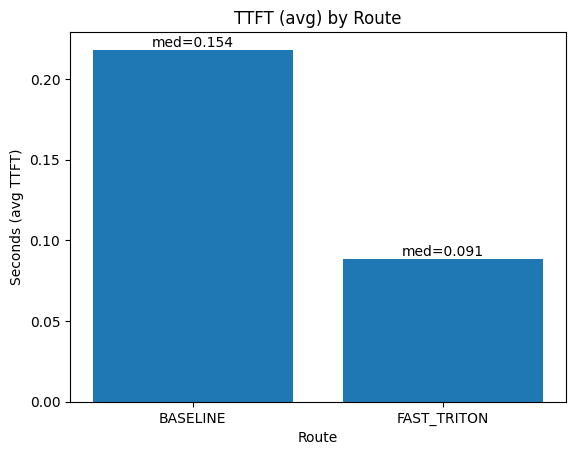

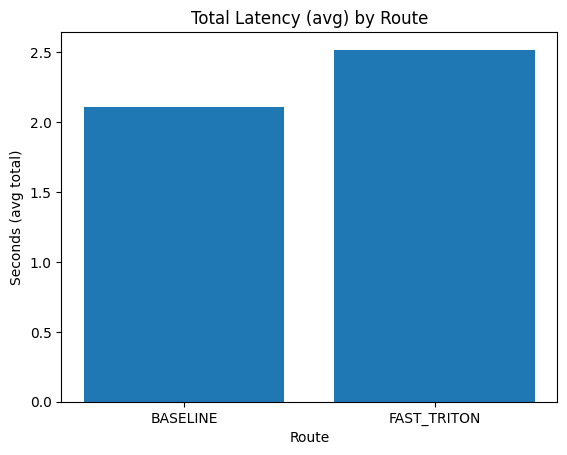

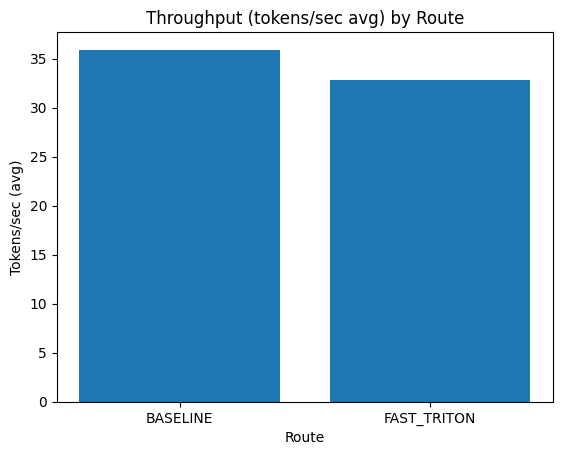

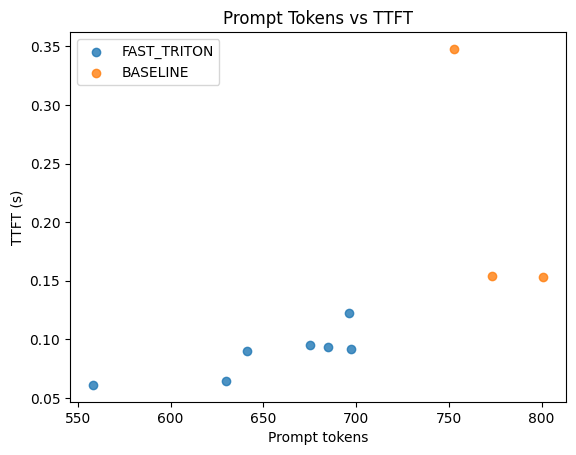

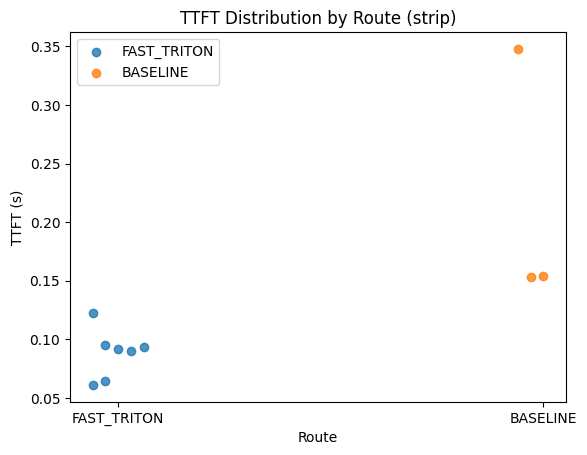

In [10]:
import time
import statistics as stats
from typing import List, Dict, Any, Optional

import pandas as pd
import matplotlib.pyplot as plt


# -----------------------------
# Route normalization (no ROUTE_RENAME)
# -----------------------------
def _rename_route(route: Optional[str]) -> str:
    if not route:
        return "UNKNOWN"
    r = str(route).strip().upper()
    if r in {"FAST", "FAST_HF", "FAST_HTTP", "FAST_TRITON"} or "FAST_TRITON" in r:
        return "FAST_TRITON"
    if r in {"BASE", "BASELINE"} or "BASELINE" in r:
        return "BASELINE"
    if r in {"ERROR"}:
        return "ERROR"
    return str(route)


# -----------------------------
# Benchmark runner
# -----------------------------
def run_benchmark(
    questions: List[str],
    top_k: int = 4,
    max_new_tokens: int = 120,
    sleep_s: float = 0.0
) -> List[Dict[str, Any]]:
    results = []
    for i, q in enumerate(questions, 1):
        print(f"\n==== [{i}/{len(questions)}] Q: {q[:120]}{'...' if len(q)>120 else ''}")
        try:
            r = answer(q, top_k=top_k, max_new_tokens=max_new_tokens)
        except Exception as e:
            r = {
                "route": "ERROR",
                "reason": f"{type(e).__name__}: {e}",
                "question": q,
                "hits": [],
                "answer_text": "",
                "metrics": {},
            }
            print(f"ERROR: {e}")

        r["question"] = r.get("question", q)
        r["route"] = r.get("route", "UNKNOWN")

        results.append(r)

        if sleep_s > 0:
            time.sleep(sleep_s)
    return results


# -----------------------------
# Robust numeric extraction
# -----------------------------
def _safe_num(x, default=None):
    return x if isinstance(x, (int, float)) else default


# -----------------------------
# Summary aggregation
# Works with BOTH shapes:
#   (A) r["metrics"] dict
#   (B) flat top-level metrics
# -----------------------------
def summarize_results(results: List[Dict[str, Any]]) -> Dict[str, Any]:
    rows = []
    for r in results:
        m = r.get("metrics", {}) or {}
        route = _rename_route(r.get("route"))

        prompt_tokens = _safe_num(m.get("prompt_tokens"), _safe_num(r.get("prompt_tokens")))
        free_vram_mb = _safe_num(m.get("free_vram_mb"), _safe_num(r.get("free_vram_mb")))
        ttft_s = _safe_num(m.get("ttft_s"), _safe_num(r.get("ttft_s")))

        total_s = _safe_num(
            m.get("total_latency_s"),
            _safe_num(m.get("total_s"), _safe_num(r.get("total_s")))
        )

        tok_s = _safe_num(
            m.get("tokens_per_sec"),
            _safe_num(m.get("tok_s"), _safe_num(r.get("tok_per_s")))
        )

        gen_tokens = _safe_num(m.get("gen_tokens"), _safe_num(r.get("gen_tokens")))

        rows.append({
            "route": route,
            "prompt_tokens": prompt_tokens,
            "free_vram_mb": free_vram_mb,
            "ttft_s": ttft_s,
            "total_s": total_s,
            "tok_s": tok_s,
            "gen_tokens": gen_tokens,
            "reason": r.get("reason", ""),
            "question": r.get("question", ""),
        })

    def group_stats(route: str):
        rs = [x for x in rows if x["route"] == route and x["ttft_s"] is not None]
        if not rs:
            return {}
        ttft = [x["ttft_s"] for x in rs if x["ttft_s"] is not None]
        total = [x["total_s"] for x in rs if x["total_s"] is not None]
        toks = [x["tok_s"] for x in rs if x["tok_s"] is not None]
        return {
            "n": len(rs),
            "ttft_avg": sum(ttft)/len(ttft) if ttft else None,
            "ttft_med": stats.median(ttft) if ttft else None,
            "total_avg": sum(total)/len(total) if total else None,
            "tok_s_avg": sum(toks)/len(toks) if toks else None,
        }

    counts = {}
    for x in rows:
        counts[x["route"]] = counts.get(x["route"], 0) + 1

    return {
        "counts": counts,
        "FAST_TRITON": group_stats("FAST_TRITON"),
        "BASELINE": group_stats("BASELINE"),
        "ERROR": group_stats("ERROR"),
        "rows": rows,
    }


# -----------------------------
# Pretty-print summary
# -----------------------------
def print_summary(summary: Dict[str, Any], max_rows: int = 12):
    print("\n\n==================== SUMMARY ====================")
    print("Route counts:", summary["counts"])

    for route in ["FAST_TRITON", "BASELINE"]:
        s = summary.get(route, {})
        if not s:
            print(f"\n{route}: no successful runs")
            continue
        print(f"\n{route}: n={s['n']}")
        print(f"  TTFT avg={s['ttft_avg']:.4f}s | med={s['ttft_med']:.4f}s")
        if s.get("tok_s_avg") is not None:
            print(f"  tok/s avg={s['tok_s_avg']:.2f}")
        if s.get("total_avg") is not None:
            print(f"  total avg={s['total_avg']:.4f}s")

    print("\nSample rows:")
    rows = summary["rows"][:max_rows]
    for i, r in enumerate(rows, 1):
        print(f"[{i}] {r['route']:11} ttft={r['ttft_s']} total={r['total_s']} tok/s={r['tok_s']} "
              f"ptoks={r['prompt_tokens']} vram={r['free_vram_mb']} | {r['question'][:80]}")


# -----------------------------
# DF conversion
# -----------------------------
def to_dataframe(summary: Dict[str, Any]) -> pd.DataFrame:
    df = pd.DataFrame(summary["rows"]).copy()
    for col in ["prompt_tokens", "free_vram_mb", "ttft_s", "total_s", "tok_s", "gen_tokens"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    return df


# -----------------------------
# Route comparison
# -----------------------------
def print_route_comparison(summary: Dict[str, Any]):
    fast = summary.get("FAST_TRITON", {})
    base = summary.get("BASELINE", {})
    if not fast or not base:
        print("Need successful runs in both FAST_TRITON and BASELINE to compute deltas.")
        return

    def pct(a, b):
        if a is None or b is None or b == 0:
            return None
        return 100.0 * (a - b) / b

    print("\n==================== ROUTE COMPARISON ====================")
    print(f"FAST_TRITON n={fast['n']} | BASELINE n={base['n']}")

    ttft_delta = fast["ttft_avg"] - base["ttft_avg"]
    print(f"TTFT avg:  FAST_TRITON={fast['ttft_avg']:.4f}s vs BASELINE={base['ttft_avg']:.4f}s"
          f" | delta={ttft_delta:+.4f}s | pct={pct(fast['ttft_avg'], base['ttft_avg']):+.1f}%")

    if fast.get("total_avg") is not None and base.get("total_avg") is not None:
        total_delta = fast["total_avg"] - base["total_avg"]
        print(f"Total avg: FAST_TRITON={fast['total_avg']:.4f}s vs BASELINE={base['total_avg']:.4f}s"
              f" | delta={total_delta:+.4f}s | pct={pct(fast['total_avg'], base['total_avg']):+.1f}%")

    if fast.get("tok_s_avg") is not None and base.get("tok_s_avg") is not None:
        tok_delta = fast["tok_s_avg"] - base["tok_s_avg"]
        print(f"Tok/s avg: FAST_TRITON={fast['tok_s_avg']:.2f} vs BASELINE={base['tok_s_avg']:.2f}"
              f" | delta={tok_delta:+.2f} | pct={pct(fast['tok_s_avg'], base['tok_s_avg']):+.1f}%")


# -----------------------------
# Plots
# -----------------------------
def plot_comparison(df: pd.DataFrame):
    routes = ["FAST_TRITON", "BASELINE"]
    d = df[df["route"].isin(routes)].copy()

    if d.empty:
        print("No data to plot (no FAST_TRITON/BASELINE rows).")
        return

    agg = d.groupby("route").agg(
        n=("ttft_s", lambda x: x.notna().sum()),
        ttft_avg=("ttft_s", "mean"),
        ttft_med=("ttft_s", "median"),
        total_avg=("total_s", "mean"),
        tok_s_avg=("tok_s", "mean"),
    ).reset_index()

    # 1) TTFT avg (+ median annotation)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.bar(agg["route"], agg["ttft_avg"])
    ax.set_title("TTFT (avg) by Route")
    ax.set_xlabel("Route")
    ax.set_ylabel("Seconds (avg TTFT)")
    for i, row in agg.iterrows():
        if pd.notna(row["ttft_med"]) and pd.notna(row["ttft_avg"]):
            ax.text(i, row["ttft_avg"], f"med={row['ttft_med']:.3f}", ha="center", va="bottom")
    plt.show()

    # 2) Total latency avg
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.bar(agg["route"], agg["total_avg"])
    ax.set_title("Total Latency (avg) by Route")
    ax.set_xlabel("Route")
    ax.set_ylabel("Seconds (avg total)")
    plt.show()

    # 3) Tokens/sec avg
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.bar(agg["route"], agg["tok_s_avg"])
    ax.set_title("Throughput (tokens/sec avg) by Route")
    ax.set_xlabel("Route")
    ax.set_ylabel("Tokens/sec (avg)")
    plt.show()

    # 4) Scatter: prompt_tokens vs TTFT
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for route in routes:
        sub = d[d["route"] == route]
        ax.scatter(sub["prompt_tokens"], sub["ttft_s"], label=route, alpha=0.8)
    ax.set_title("Prompt Tokens vs TTFT")
    ax.set_xlabel("Prompt tokens")
    ax.set_ylabel("TTFT (s)")
    ax.legend()
    plt.show()

    # 5) TTFT distribution strip plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    x_map = {r: i for i, r in enumerate(routes)}
    for route in routes:
        sub = d[d["route"] == route]
        xs = [x_map[route] + (0.03 * (i % 5 - 2)) for i in range(len(sub))]
        ax.scatter(xs, sub["ttft_s"], alpha=0.8, label=route)
    ax.set_title("TTFT Distribution by Route (strip)")
    ax.set_xlabel("Route")
    ax.set_ylabel("TTFT (s)")
    ax.set_xticks(list(x_map.values()))
    ax.set_xticklabels(routes)
    ax.legend()
    plt.show()


# -----------------------------
# Question set
# -----------------------------
questions = [
    "What is TTFT in LLM inference?",
    "Explain tokens per second and why it matters.",
    "Summarize how a RAG system retrieves context before generation.",
    "What is the difference between TensorRT-LLM and Triton?",
    "Give a 6-point checklist to diagnose high TTFT on GPU inference.",
    "Explain why long context windows can increase latency even before generation starts.",
    "What does 'KV cache' mean and how does it affect inference performance?",
    "Write a short explanation of why routing between fast and baseline inference helps GPU efficiency.",
    "What metrics should I log to compare two inference routes fairly?",
    "Explain how VRAM availability affects batch size and throughput.",
]


# -----------------------------
# Run + summarize + visualize
# -----------------------------
results = run_benchmark(questions, top_k=4, max_new_tokens=120, sleep_s=0.2)
summary = summarize_results(results)

print_summary(summary)
print_route_comparison(summary)

df = to_dataframe(summary)
display(df.head(10))

plot_comparison(df)